In [3]:
import importlib, tools
importlib.reload(tools)
from tools import path_from_root, relative_paths_in_dir

# %matplotlib qt
%matplotlib inline

In [4]:
from typing import Generator
from PIL import Image
import os
import shutil
from itertools import product


def extract_samples_from_file(
    file: str, sample_size: int | tuple[int]
) -> Generator[Image.Image, None, None]:
    sample_X, sample_Y = (
        (sample_size, sample_size) if isinstance(
            sample_size, int) else sample_size
    )
    with Image.open(file) as img:
        if img.mode == "RGBA":
            img = img.convert("RGB")
        for x, y in product(
            range(int(img.size[0] / sample_X)
                  ), range(int(img.size[1] / sample_Y))
        ):
            left = x * sample_X
            top = y * sample_Y
            yield img.crop((left, top, left + sample_X, top + sample_Y))


def sources_of_texture(kind: str) -> Generator[str, None, list]:
    return (
        path_from_root("textures", kind, img)
        for img in os.listdir(path_from_root("textures", kind))
    )


SAMPLE_SIZE = 128
for kind, folder in relative_paths_in_dir(path_from_root("textures")):
    if not os.path.isdir(folder) or kind[0] == ".":
        continue

    out_folder = path_from_root("samples", kind)
    if os.path.exists(out_folder):
        shutil.rmtree(out_folder)
    os.mkdir(out_folder)

    sample_gen = (
        sample
        for src in sources_of_texture(kind)
        for sample in extract_samples_from_file(src, SAMPLE_SIZE)
    )
    for i, sample in enumerate(sample_gen):
        sample.save(path_from_root(out_folder, f"{i}.jpg"))
    print(f"{i+1} samples created from {kind} textures")

1409 samples created from bricks textures
183 samples created from leather textures
540 samples created from mosaic textures
450 samples created from wood textures


In [8]:
from skimage.feature import graycomatrix, graycoprops
from skimage.io import imread
import numpy as np
import csv
import itertools

# from skimage.color import rgb2gray
# from skimage.exposure import rescale_intensity

PROPS = ("dissimilarity", "correlation",
         "contrast", "energy", "homogeneity", "ASM")
DISTANCES = (1, 3, 5)
ANGLES = (0, 45, 90, 135)
LEVELS = 2**6

PROPS_FILE = path_from_root("props_vectors.csv")

with open(PROPS_FILE, "w", newline="") as fp:
    wrrr = csv.writer(fp)
    wrrr.writerow(("kind", *(f"{p}_{d}_{a}deg" for p, d,
                  a in itertools.product(PROPS, DISTANCES, ANGLES))))

    for kind, folder in relative_paths_in_dir(path_from_root("samples")):
        for _, fpath in relative_paths_in_dir(folder):
            img = (imread(fpath, as_gray=True) * (LEVELS - 1)).astype(np.uint8)
            P = graycomatrix(img, DISTANCES, np.radians(ANGLES), levels=LEVELS)
            arr = np.concatenate(
                [graycoprops(P, prop).reshape(1, -1) for prop in PROPS], axis=0)
            wrrr.writerow((kind, *arr.flat))

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import svm

df = pd.read_csv(PROPS_FILE)

TEST_SIZE = 0.1
train, test = train_test_split(df, test_size=TEST_SIZE)

clf = svm.SVC(gamma="auto")
ficzers = df.columns.drop("kind")
svc = clf.fit(train.loc[:, ficzers], train["kind"])

Accuracy: 0.9459 with set size of 2582 samples and 0.1 test ratio


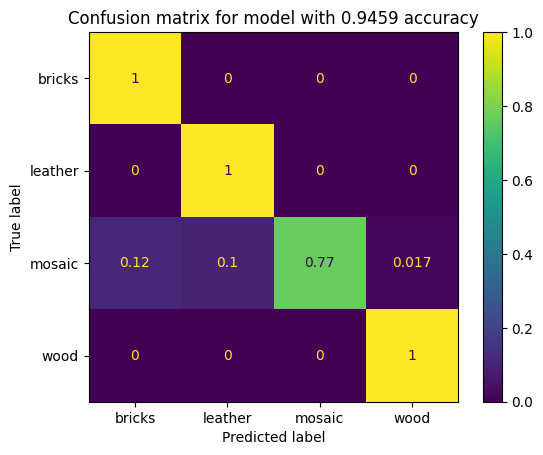

In [41]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

result = clf.predict(test.loc[:, ficzers])

acc = accuracy_score(test["kind"], result)
print(

    f"Accuracy: {acc:.4f} with set size of {df.shape[0]} samples and {TEST_SIZE} test ratio"
)

cm = confusion_matrix(result, test["kind"], normalize="true")
disp = ConfusionMatrixDisplay(
    cm,
    display_labels=df["kind"].unique(),
)
_ = disp.plot().ax_.set_title(f"Confusion matrix for model with {acc:.4f} accuracy")